*Technical University of Munich<br>
Professorship of Environmental Sensing and Modeling<br><br>*
**Author:**  Daniel Kühbacher<br>
**Date:**  07.10.2024

--- 

# Uncertainty of the single detector emission estimate

<!--Notebook description and usage information-->
TBD


In [1]:
import sys

import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import time

sys.path.append('../../utils')
import data_paths
from hbefa_hot_emissions import HbefaHotEmissions
from hot_emission_process import process_hourly_emissions
from traffic_counts import TrafficCounts

In [2]:
# initialize hbefa 
hbefa_obj = HbefaHotEmissions()
# initialize traffic cycles
cycles = TrafficCounts()
# import visum data
visum_links = gpd.read_file(data_paths.VISUM_FOLDER_PATH + 'visum_links.gpkg')

Loaded emission factors from /Users/daniel_tum/Documents/projects/traffic inventory v2/traffic-emission-inventory/data/restricted_input/hbefa/EFA_HOT_Vehcat_PC.XLS
Loaded emission factors from /Users/daniel_tum/Documents/projects/traffic inventory v2/traffic-emission-inventory/data/restricted_input/hbefa/EFA_HOT_Vehcat_LCV.XLS
Loaded emission factors from /Users/daniel_tum/Documents/projects/traffic inventory v2/traffic-emission-inventory/data/restricted_input/hbefa/EFA_HOT_Vehcat_HGV.XLS
Loaded emission factors from /Users/daniel_tum/Documents/projects/traffic inventory v2/traffic-emission-inventory/data/restricted_input/hbefa/EFA_HOT_Vehcat_Coach.XLS
Loaded emission factors from /Users/daniel_tum/Documents/projects/traffic inventory v2/traffic-emission-inventory/data/restricted_input/hbefa/EFA_HOT_Vehcat_MOT.XLS
Loaded emission factors from /Users/daniel_tum/Documents/projects/traffic inventory v2/traffic-emission-inventory/data/restricted_input/hbefa/ef_aggregated_los/EFA_HOT_Vehcat

# Import detector-based emissions for comparison

In [3]:
# import detector emission data
_fname = data_paths.INVENTORY_FOLDER_PATH + 'DetectorEmissions_2019_vc_estimate.feather'
#_fname = data_paths.INVENTORY_FOLDER_PATH + 'DetectorEmissions_2019.feather'
df = pd.read_feather(_fname)

# Use Inventory Model to calculate the Emission

In [4]:
road_links_with_detectors = df['road_link_id'].unique()
visum_reduced = visum_links[visum_links['road_link_id']\
    .isin(road_links_with_detectors)].copy()
visum_reduced = visum_reduced.reset_index(drop=True).reset_index()

In [5]:
final_emissions = list()

for day in pd.date_range(start='2019-01-01', end= '2019-12-31', freq = 'd'): # for all days in 2019
    
    em_dict = process_hourly_emissions(day.strftime('%Y-%m-%d'),
                                        visum_reduced.to_dict('records'),
                                        cycles,
                                        hbefa_obj)
    
    df_temp = pd.DataFrame()
    for road_link_index, item in em_dict.items():
        
        data = pd.DataFrame(pd.Series(item).reset_index())
        data.rename(columns = {'level_0':'vehicle_class',
                               'level_1':'component',
                               'level_2':'hour',
                               0:'emission'},
                    inplace = True)
        data['date'] = day
        data['road_link_index'] = road_link_index
        df_temp = pd.concat([df_temp, data], axis = 0)
    final_emissions.append(df_temp)
model_dat = pd.concat(final_emissions)
model_dat['road_link_id'] = model_dat['road_link_index'].map(visum_reduced['road_link_id'].to_dict())
model_dat['timestamp'] = model_dat.apply(lambda row: pd.Timestamp.combine(row['date'],
                                                                          time(row['hour'])), axis = 1)

In [377]:
# serialize table
model_dat_long = model_dat.groupby(['vehicle_class',
                             'timestamp',
                             'road_link_id',
                             'component'])['emission'].sum().reset_index()

model_dat_long = model_dat_long.pivot(index = ['road_link_id', 'timestamp'],
                                      columns=['component', 'vehicle_class'],
                                      values = 'emission')

model_dat_long.head()

component                        BC (exhaust)       CH4        CO  \
vehicle_class                             BUS       BUS       BUS   
road_link_id timestamp                                              
38           2019-01-01 00:00:00     0.034896  0.002305  2.124496   
             2019-01-01 01:00:00     0.069793  0.004611  4.248992   
             2019-01-01 02:00:00     0.034896  0.002305  2.124496   
             2019-01-01 03:00:00     0.000000  0.000000  0.000000   
             2019-01-01 04:00:00     0.034896  0.002305  2.124496   

component                            CO2(rep)   CO2(total)         CO2e  \
vehicle_class                             BUS          BUS          BUS   
road_link_id timestamp                                                    
38           2019-01-01 00:00:00   592.828397   625.359209   612.936473   
             2019-01-01 01:00:00  1185.656793  1250.718417  1225.872945   
             2019-01-01 02:00:00   592.828397   625.359209   612.936473   
             2019-01-01 03:00:00     0.000000     0.000000     0.000000   
             2019-01-01 04:00:00   592.828397   625.359209   612.936473   

component                              NO2       NOx        PM BC (exhaust)  \
vehicle_class                          BUS       BUS       BUS          HGV   
road_link_id timestamp                                                        
38           2019-01-01 00:00:00  0.457933  4.654480  0.056336     0.460366   
             2019-01-01 01:00:00  0.915865  9.308961  0.112673     0.575457   
             2019-01-01 02:00:00  0.457933  4.654480  0.056336     0.460366   
             2019-01-01 03:00:00  0.000000  0.000000  0.000000     0.460366   
             2019-01-01 04:00:00  0.457933  4.654480  0.056336     0.460366   

component                         ...        PM BC (exhaust)       CH4  \
vehicle_class                     ...       MOT           PC        PC   
road_link_id timestamp            ...                                    
38           2019-01-01 00:00:00  ...  0.149722     1.189688  3.756381   
             2019-01-01 01:00:00  ...  0.149722     0.937458  2.959975   
             2019-01-01 02:00:00  ...  0.149722     0.626373  1.977741   
             2019-01-01 03:00:00  ...  0.000000     0.517073  1.632632   
             2019-01-01 04:00:00  ...  0.000000     0.466627  1.473351   

component                                 CO      CO2(rep)    CO2(total)  \
vehicle_class                             PC            PC            PC   
road_link_id timestamp                                                     
38           2019-01-01 00:00:00  408.070202  91375.480036  95831.688733   
             2019-01-01 01:00:00  321.553551  72002.586743  75514.016210   
             2019-01-01 02:00:00  214.849682  48109.351680  50455.553432   
             2019-01-01 03:00:00  177.359134  39714.431253  41651.228672   
             2019-01-01 04:00:00  160.055804  35839.852594  37587.694168   

component                                 CO2e        NO2         NOx  \
vehicle_class                               PC         PC          PC   
road_link_id timestamp                                                  
38           2019-01-01 00:00:00  92550.759918  41.801751  220.990403   
             2019-01-01 01:00:00  72928.690677  32.939189  174.137314   
             2019-01-01 02:00:00  48728.138614  22.008696  116.351838   
             2019-01-01 03:00:00  40225.241943  18.168252   96.048832   
             2019-01-01 04:00:00  36300.828095  16.395740   86.678215   

component                               PM  
vehicle_class                           PC  
road_link_id timestamp                      
38           2019-01-01 00:00:00  2.227193  
             2019-01-01 01:00:00  1.754997  
             2019-01-01 02:00:00  1.172621  
             2019-01-01 03:00:00  0.968003  
             2019-01-01 04:00:00  0.873563  

[5 rows x 45 columns]

In [460]:
df

,road_link_id,road_type,timestamp,BUS,HGV,LCV,MOT,PC,SUM_PCU,speed,...,PC_NOx,LCV_NOx,HGV_NOx,BUS_NOx,MOT_NOx,PC_CO,LCV_CO,HGV_CO,BUS_CO,MOT_CO
0,3.800000e+01,TrunkRoad/Primary-City,2019-01-05 00:00:00,7.0,37.0,64.0,0.0,970.0,1138.75,60,...,323.967821,52.447964,66.147866,22.507666,0.000000,579.913599,20.411354,30.791973,11.521091,0.000000
1,3.800000e+01,TrunkRoad/Primary-City,2019-01-05 01:00:00,3.0,42.0,55.0,2.0,536.0,703.25,60,...,179.017270,45.072469,75.086767,9.646143,0.177144,320.447102,17.541007,34.953050,4.937610,7.414128
2,3.800000e+01,TrunkRoad/Primary-City,2019-01-05 02:00:00,1.0,35.0,52.0,1.0,333.0,475.25,60,...,111.217819,42.613971,62.572306,3.215381,0.088572,199.083741,16.584225,29.127542,1.645870,3.707064
3,3.800000e+01,TrunkRoad/Primary-City,2019-01-05 03:00:00,1.0,29.0,36.0,8.0,296.0,414.25,60,...,98.860284,29.501980,51.845625,3.215381,0.708578,176.963325,11.481387,24.134249,1.645870,29.656513
4,3.800000e+01,TrunkRoad/Primary-City,2019-01-05 04:00:00,2.0,35.0,37.0,3.0,400.0,531.00,60,...,133.594978,30.321479,62.572306,6.430762,0.265717,239.139628,11.800314,29.127542,3.291740,11.121192
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377659,2.147483e+09,Distributor/Secondary,2019-12-29 19:00:00,18.0,2.0,33.0,3.0,753.0,825.50,50,...,251.550938,24.137245,4.956053,77.936265,0.242093,180.041331,6.811717,2.266842,33.166156,10.521918
377660,2.147483e+09,Distributor/Secondary,2019-12-29 20:00:00,29.0,4.0,34.0,7.0,657.0,758.75,50,...,219.480699,24.868677,9.912106,125.563982,0.564884,157.087854,7.018133,4.533685,53.434363,24.551143
377661,2.147483e+09,Distributor/Secondary,2019-12-29 21:00:00,24.0,1.0,29.0,5.0,582.0,660.50,50,...,194.425824,21.211518,2.478026,103.915020,0.403489,139.155451,5.986054,1.133421,44.221541,17.536530
377662,2.147483e+09,Distributor/Secondary,2019-12-29 22:00:00,23.0,6.0,27.0,4.0,448.0,534.25,50,...,149.661116,19.748655,14.868158,99.585227,0.322791,107.116223,5.573223,6.800527,42.378977,14.029224


# Prepare combined dataset

In [385]:
component = 'CO2(rep)'



detector_em = df.groupby(['road_link_id',
                          'timestamp'])[[f'{x}_{component}' for x in hbefa_obj.vehicle_classes]].sum()

model_hourly_co2_sum = model_dat_long[component].sum(axis =1)
ground_truth_hourly_co2_sum = ground_truth_em.sum(axis=1)

comp_df = pd.concat([ground_truth_hourly_co2_sum, 
                     model_hourly_co2_sum], axis =1).dropna()

comp_df_base = comp_df[(comp_df[0]>1) &
                       (comp_df[1]>1)]

comp_df_base = comp_df_base.rename(columns = {0: 'true_em', 1: 'modeled_em'})
comp_df_base.head()

true_em    modeled_em
road_link_id timestamp                                       
38.0         2019-01-05 00:00:00  171772.675476  92202.211301
             2019-01-05 01:00:00  108772.093597  62066.455037
             2019-01-05 02:00:00   74877.521797  48929.105814
             2019-01-05 03:00:00   64173.521576  43495.237939
             2019-01-05 04:00:00   82121.722557  47804.559356

# Calculate hourly differences

-117.72147999398534
72.36956145290999


<Axes: xlabel='diff_rel', ylabel='Count'>

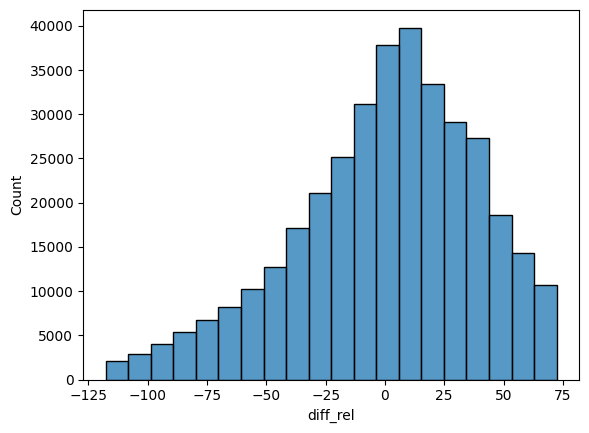

In [386]:
hourly_comp = comp_df_base.copy()
hourly_comp['diff'] = hourly_comp['true_em'] - hourly_comp['modeled_em']
hourly_comp['diff_rel'] = (hourly_comp['diff']/ hourly_comp['true_em'])*100

vals = hourly_comp['diff_rel'][np.isfinite(hourly_comp['diff_rel'].to_numpy())]
lb = np.nanpercentile(vals, 2.5)
ub = np.percentile(vals, 97.5)

print(lb)
print(ub)
#print(vals.median())

sns.histplot(hourly_comp, x='diff_rel',  binrange= (lb, ub), bins= 20)

# Calculate Daily Differences

-88.56534803684121
70.4212373922652
3.6254670733091094


<Axes: xlabel='diff_rel', ylabel='Count'>

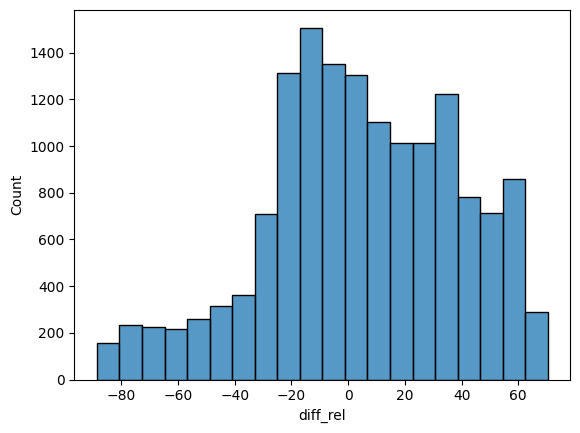

In [387]:
daily_comp = comp_df_base.reset_index().set_index('timestamp').copy()
daily_comp = daily_comp.groupby('road_link_id').resample('D').sum()

daily_comp['diff'] = daily_comp['true_em'] - daily_comp['modeled_em']
daily_comp['diff_rel'] = (daily_comp['diff']/daily_comp['true_em'])*100

vals = daily_comp['diff_rel'][np.isfinite(daily_comp['diff_rel'].to_numpy())]
lb = np.nanpercentile(vals, 2.5)
ub = np.percentile(vals, 97.5)

print(lb)
print(ub)
print(np.mean(vals))
sns.histplot(daily_comp, x='diff_rel',  binrange= (lb, ub), bins= 20)

# Calculate Annual Differences

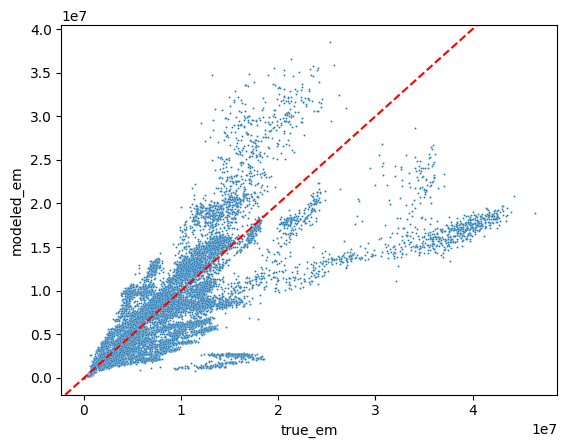

In [388]:
sns.scatterplot(data = daily_comp, x='true_em', y='modeled_em', s = 2)
plt.axline([0,0], [1,1], color = 'red', linestyle = '--')

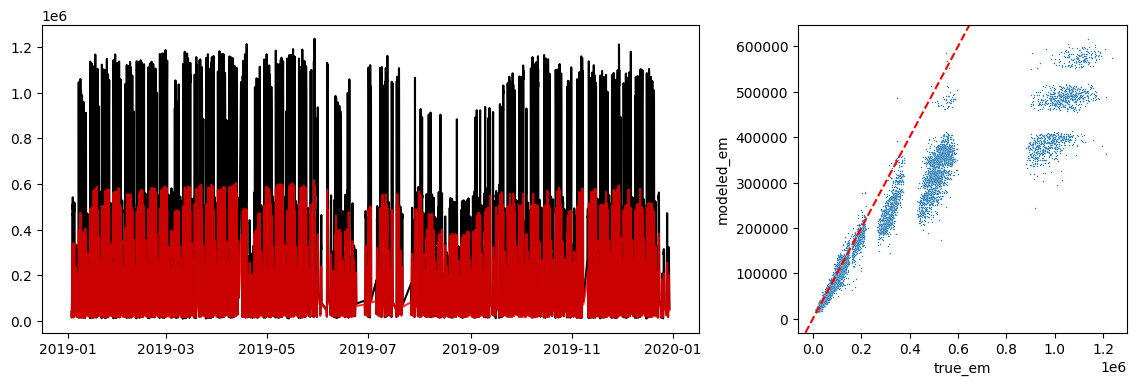

In [459]:
rl = comp_df_base.index.get_level_values(level =0).unique()
idx = 63

###
#
# PLOTTING
#
###

fig, ax = plt.subplots(1,2, width_ratios=(2,1), figsize = (14, 4))
ax[0].plot(comp_df_base.loc[rl[idx]]['true_em'], label = 'true', color = 'black')
ax[0].plot(comp_df_base.loc[rl[idx]]['modeled_em'], label = 'modeled', alpha = 0.8, color = 'red')

sns.scatterplot(ax = ax[1], data = comp_df_base.loc[rl[idx]], x='true_em', y='modeled_em', s = 1)
ax[1].axline([0,0], [1,1], color = 'red', linestyle = '--')